# MLP Classification with CR Dataset
<hr>

We will build a text classification model using MLP model on the Customer Reviews Dataset. Since there is no standard train/test split for this dataset, we will use 10-Fold Cross Validation (CV). 

## Load the library

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
from nltk.corpus import stopwords, twitter_samples
# from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import KFold
from nltk.stem import PorterStemmer
from string import punctuation
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
import time

%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False
# nltk.download('twitter_samples')

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load the Dataset

In [3]:
corpus = pd.read_pickle('../../0_data/CR/CR.pkl')
corpus.label = corpus.label.astype(int)
print(corpus.shape)
corpus

(3775, 3)


,sentence,label,split
0,weaknesses are minor the feel and layout of th...,0,train
1,many of our disney movies do n 't play on this...,0,train
2,player has a problem with dual layer dvd 's su...,0,train
3,i know the saying is you get what you pay for ...,0,train
4,will never purchase apex again .,0,train
...,...,...,...
3770,"so far , the anti spam feature seems to be ver...",1,train
3771,i downloaded a trial version of computer assoc...,1,train
3772,i did not have any of the installation problem...,1,train
3773,their products have been great and have saved ...,1,train


In [4]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3775 entries, 0 to 3774
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  3775 non-null   object
 1   label     3775 non-null   int32 
 2   split     3775 non-null   object
dtypes: int32(1), object(2)
memory usage: 73.9+ KB


In [5]:
corpus.groupby( by='label').count()

,sentence,split
label,,
0,1368,1368
1,2407,2407


In [6]:
# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

## Raw Number of Vocabulary

In [7]:
# Build the raw vocobulary for first inspection
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_raw = tokenizer.word_index
print('\nThe vocabulary size: {}\n'.format(len(vocab_raw)))
print(vocab_raw)


The vocabulary size: 5334

{'the': 1, 'and': 2, 'i': 3, 'it': 4, 'to': 5, 'a': 6, 'is': 7, 'of': 8, 'this': 9, 'with': 10, 'for': 11, 'you': 12, 'that': 13, 'in': 14, 'have': 15, 'but': 16, 'not': 17, 'on': 18, 'my': 19, "'t": 20, 'as': 21, "'s": 22, 'are': 23, 'very': 24, 'can': 25, 'was': 26, 'use': 27, 'camera': 28, 'player': 29, 'all': 30, 'has': 31, 'phone': 32, 'great': 33, 'one': 34, 'be': 35, 'so': 36, 'at': 37, 'if': 38, 'good': 39, 'easy': 40, 'quality': 41, 'or': 42, 'up': 43, 'from': 44, 'no': 45, 'like': 46, 'an': 47, 'than': 48, 'had': 49, 'just': 50, 'battery': 51, 'get': 52, 'about': 53, 'when': 54, 'software': 55, 'only': 56, 'your': 57, 'ipod': 58, 'would': 59, 'which': 60, 'well': 61, 'they': 62, 'also': 63, 'more': 64, 'sound': 65, 'there': 66, 'me': 67, 'n': 68, 'other': 69, 'do': 70, 'will': 71, 'out': 72, 'does': 73, 'any': 74, "'ve": 75, 'features': 76, 'its': 77, 'zen': 78, 'router': 79, 'even': 80, 'some': 81, 'really': 82, 'by': 83, 'better': 84, 'after': 85

<!--## Split Dataset-->

# Data Preprocessing
<hr>

## Define `clean_doc` function

In [8]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

## Develop Vocabulary

A part of preparing text for text classification involves defining and tailoring the vocabulary of words supported by the model. **We can do this by loading all of the documents in the dataset and building a set of words.**

The larger the vocabulary, the more sparse the representation of each word or document. So, we may decide to support all of these words, or perhaps discard some. The final chosen vocabulary can then be saved to a file for later use, such as filtering words in new documents in the future.

We can use `Counter` class and create an instance called `vocab` as follows:

In [9]:
from collections import Counter

vocab = Counter()

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab

In [10]:
# Example
add_doc_to_vocab(sentences, vocab)
print(len(vocab))
vocab

3714


Counter({'weak': 12,
         'minor': 9,
         'feel': 48,
         'layout': 5,
         'remot': 30,
         'control': 84,
         'n': 144,
         'show': 16,
         'complet': 19,
         'file': 89,
         'name': 13,
         'mp3': 73,
         'realli': 119,
         'long': 56,
         'must': 26,
         'cycl': 3,
         'everi': 40,
         'zoom': 51,
         'set': 87,
         '2x': 3,
         '3x': 8,
         '4x': 6,
         '1': 93,
         'etc': 42,
         'get': 243,
         'back': 46,
         'normal': 21,
         'size': 76,
         'sorri': 2,
         'ignor': 2,
         'way': 68,
         '1x': 1,
         'quickli': 20,
         'mani': 70,
         'disney': 2,
         'movi': 26,
         'play': 142,
         'dvd': 113,
         'player': 331,
         'problem': 202,
         'dual': 3,
         'layer': 3,
         'alia': 2,
         'season': 3,
         '2': 102,
         'know': 43,
         'say': 60,
         'pay

In [11]:
vocab.items()

dict_items([('weak', 12), ('minor', 9), ('feel', 48), ('layout', 5), ('remot', 30), ('control', 84), ('n', 144), ('show', 16), ('complet', 19), ('file', 89), ('name', 13), ('mp3', 73), ('realli', 119), ('long', 56), ('must', 26), ('cycl', 3), ('everi', 40), ('zoom', 51), ('set', 87), ('2x', 3), ('3x', 8), ('4x', 6), ('1', 93), ('etc', 42), ('get', 243), ('back', 46), ('normal', 21), ('size', 76), ('sorri', 2), ('ignor', 2), ('way', 68), ('1x', 1), ('quickli', 20), ('mani', 70), ('disney', 2), ('movi', 26), ('play', 142), ('dvd', 113), ('player', 331), ('problem', 202), ('dual', 3), ('layer', 3), ('alia', 2), ('season', 3), ('2', 102), ('know', 43), ('say', 60), ('pay', 15), ('stage', 1), ('game', 29), ('better', 111), ('qualiti', 218), ('excus', 1), ('never', 49), ('purchas', 69), ('apex', 46), ('custom', 42), ('servic', 61), ('technic', 5), ('support', 69), ('overload', 2), ('non', 12), ('respons', 9), ('tell', 24), ('product', 130), ('willing', 1), ('stand', 15), ('behind', 4), ('wou

In [12]:
# #########################
# # Define the vocabulary #
# #########################

# from collections import Counter
# from nltk.corpus import stopwords
# stopwords = stopwords.words('english')
# stemmer = PorterStemmer()
    
# def clean_doc(doc):
#     # split into tokens by white space
#     tokens = doc.split()
#     # prepare regex for char filtering
#     re_punc = re.compile('[%s]' % re.escape(punctuation))
#     # remove punctuation from each word
#     tokens = [re_punc.sub('', w) for w in tokens]
#     # filter out stop words
#     tokens = [w for w in tokens if not w in stopwords]
#     # filter out short tokens
#     tokens = [word for word in tokens if len(word) >= 1]
#     # Stem the token
#     tokens = [stemmer.stem(token) for token in tokens]
#     return tokens

# def add_doc_to_vocab(docs, vocab):
#     '''
#     input:
#         docs: a list of sentences (docs)
#         vocab: a vocabulary dictionary
#     output:
#         return an updated vocabulary
#     '''
#     for doc in docs:
#         tokens = clean_doc(doc)
#         vocab.update(tokens)
#     return vocab
        

# # prepare cross validation with 10 splits and shuffle = True
# kfold = KFold(10, True)

# # Separate the sentences and the labels
# sentences, labels = list(corpus.sentence), list(corpus.label)

# acc_list = []

# # kfold.split() will return set indices for each split
# for train, test in kfold.split(sentences):
#     # Instantiate a vocab object
#     vocab = Counter()
    
#     train_x, test_x = [], []
#     train_y, test_y = [], []
    
#     for i in train:
#         train_x.append(sentences[i])
#         train_y.append(labels[i])
    
#     for i in test:
#         test_x.append(sentences[i])
#         test_y.append(labels[i])
    
#     vocab = add_doc_to_vocab(train_x, vocab)
#     print(len(train_x), len(test_x))
#     print(len(vocab))

<dir>

# Bag-of-Words Representation
<hr>

Once we define our vocab obtained from the training data, we need to **convert each review into a representation that we can feed to a Multilayer Perceptron Model.**

As a reminder, here are the summary what we will do:
- extract features from the text so the text input can be used with ML algorithms like neural networks
- we do by converting the text into a vector representation. The larger the vocab, the longer the representation.
- we will score the words in a document inside the vector. These scores are placed in the corresponding location in the vector representation.

In [13]:
def doc_to_line(doc):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join([token for token in tokens])
    return line

In [14]:
def clean_docs(docs):
    lines = []
    for doc in docs:
        line = doc_to_line(doc)
        lines.append(line)
    return lines

In [15]:
print(sentences[:5])
clean_sentences = clean_docs(sentences[:5])
print()
print( clean_sentences)

["weaknesses are minor the feel and layout of the remote control are only so so . it does n 't show the complete file names of mp3s with really long names . you must cycle through every zoom setting ( 2x , 3x , 4x , 1 2x , etc . ) before getting back to normal size sorry if i 'm just ignorant of a way to get back to 1x quickly .", "many of our disney movies do n 't play on this dvd player .", "player has a problem with dual layer dvd 's such as alias season 1 and season 2 .", 'i know the saying is you get what you pay for but at this stage of game dvd players must have better quality than this there is no excuse .', 'will never purchase apex again .']

['weak minor feel layout remot control n show complet file name mp3 realli long name must cycl everi zoom set 2x 3x 4x 1 2x etc get back normal size sorri ignor way get back 1x quickli', 'mani disney movi n play dvd player', 'player problem dual layer dvd alia season 1 season 2', 'know say get pay stage game dvd player must better qualit

## Bag-of-Words Vectors

We will use the **Keras API** to **convert sentences to encoded document vectors**. Although the `Tokenizer` class from TF Keras provides cleaning and vocab definition, it's better we do this ourselves so that we know exactly we are doing.

In [16]:
def create_tokenizer(sentence):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

This process determines a consistent way to **convert the vocabulary to a fixed-length vector**, which is the total number of words in the vocabulary `vocab`. 

Next, documents can then be encoded using the Tokenizer by calling `texts_to_matrix()`. 

The function takes both a list of documents to encode and an encoding mode, which is the method used to score words in the document. Here we specify **freq** to score words based on their frequency in the document. 

This can be used to encode the loaded training and test data, for example:

`Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')`

`Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')`

In [17]:
# #########################
# # Define the vocabulary #
# #########################

# from collections import Counter
# from nltk.corpus import stopwords
# stopwords = stopwords.words('english')
# stemmer = PorterStemmer()
    
# def clean_doc(doc):
#     # split into tokens by white space
#     tokens = doc.split()
#     # prepare regex for char filtering
#     re_punc = re.compile('[%s]' % re.escape(punctuation))
#     # remove punctuation from each word
#     tokens = [re_punc.sub('', w) for w in tokens]
#     # filter out stop words
#     tokens = [w for w in tokens if not w in stopwords]
#     # filter out short tokens
#     tokens = [word for word in tokens if len(word) >= 1]
#     # Stem the token
#     tokens = [stemmer.stem(token) for token in tokens]
#     return tokens

# def add_doc_to_vocab(docs, vocab):
#     '''
#     input:
#         docs: a list of sentences (docs)
#         vocab: a vocabulary dictionary
#     output:
#         return an updated vocabulary
#     '''
#     for doc in docs:
#         tokens = clean_doc(doc)
#         vocab.update(tokens)
#     return vocab
        
# def doc_to_line(doc, vocab):
#     tokens = clean_doc(doc)
#     # filter by vocab
#     tokens = [token for token in tokens if token in vocab]
#     line = ' '.join(tokens)
#     return line

# def clean_docs(docs, vocab):
#     lines = []
#     for doc in docs:
#         line = doc_to_line(doc, vocab)
#         lines.append(line)
#     return lines

# def create_tokenizer(sentences):
#     tokenizer = Tokenizer()
#     tokenizer.fit_on_texts(sentences)
#     return tokenizer

# # prepare cross validation with 10 splits and shuffle = True
# kfold = KFold(10, True)

# # Separate the sentences and the labels
# sentences, labels = list(corpus.sentence), list(corpus.label)

# acc_list = []

# # kfold.split() will return set indices for each split
# for train, test in kfold.split(sentences):
#     # Instantiate a vocab object
#     vocab = Counter()
    
#     train_x, test_x = [], []
#     train_y, test_y = [], []
    
#     for i in train:
#         train_x.append(sentences[i])
#         train_y.append(labels[i])
    
#     for i in test:
#         test_x.append(sentences[i])
#         test_y.append(labels[i])
    
#     # Turn the labels into a numpy array
#     train_y = np.array(train_y)
#     test_y = np.array(test_y)
    
#     # Define a vocabulary for each fold
#     vocab = add_doc_to_vocab(train_x, vocab)
#     print('The number of vocab: ', len(vocab))
    
#     # Clean the sentences
#     train_x = clean_docs(train_x, vocab)
#     test_x = clean_docs(test_x, vocab)
    
#     # Define the tokenizer
#     tokenizer = create_tokenizer(train_x)
    
#     # encode data using freq mode
#     Xtrain = tokenizer.texts_to_matrix(train_x, mode='freq')
#     Xtest = tokenizer.texts_to_matrix(test_x, mode='freq')
   

# print(Xtrain.shape)
# print(train_x[0])
# print(Xtrain[0])
# print(Xtest.shape)
# print(test_x[0])
# print(Xtest[0])

# Training and Testing the Model 3

## MLP Model 3

Now, we will build Multilayer Perceptron (MLP) models to classify encoded documents as either positive or negative.

As you might have expected, the models are simply feedforward network with fully connected layers called `Dense` in the `Keras` library.

Now, we will define our MLP neural network with very little trial and error so cannot be considered tuned for this problem. The configuration is as follows:
- First hidden layer with 100 neurons and Relu activation function
- Second hidden layer with 50 neurons and Relu activation function
- Dropout Layer for each fully connected layer with p = 0.5
- Output layer with Sigmoid activation function
- Optimizer: Adam (The best learning algorithm so far)
- Loss function: binary cross-entropy (suited for binary classification problem)

In [18]:
def train_mlp_3(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=50, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

In [19]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                             patience=5, verbose=2, 
                                             mode='auto', restore_best_weights=True)

## Train and Test the Model

In [20]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

def train_mlp_3(train_x, train_y, test_x, test_y, batch_size = 50, epochs = 20, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=50, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose, callbacks = [callbacks], validation_data=(test_x, test_y))
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

acc_list = []

# kfold.split() will return set indices for each split
for train, test in kfold.split(sentences):
    # Instantiate a vocab object
    vocab = Counter()
    
    train_x, test_x = [], []
    train_y, test_y = [], []
    
    for i in train:
        train_x.append(sentences[i])
        train_y.append(labels[i])
    
    for i in test:
        test_x.append(sentences[i])
        test_y.append(labels[i])
    
    # Turn the labels into a numpy array
    train_y = np.array(train_y)
    test_y = np.array(test_y)
    
    # Define a vocabulary for each fold
    vocab = add_doc_to_vocab(train_x, vocab)
    # print('The number of vocab: ', len(vocab))
    
    # Clean the sentences
    train_x = clean_docs(train_x, vocab)
    test_x = clean_docs(test_x, vocab)
    
    # Define the tokenizer
    tokenizer = create_tokenizer(train_x)
    
    # encode data using freq mode
    Xtrain = tokenizer.texts_to_matrix(train_x, mode='freq')
    Xtest = tokenizer.texts_to_matrix(test_x, mode='freq')
       
    # train the model
    model = train_mlp_3(Xtrain, train_y, Xtest, test_y)
    
    # evaluate the model
    loss, acc = model.evaluate(Xtest, test_y, verbose=0)
    print('Test Accuracy: {}'.format(acc*100))
    
    acc_list.append(acc)

acc_list = np.array(acc_list)
print()
print('The test ccuracy for each training:\n{}'.format(acc_list))
print('The mean of the test accuracy: ', acc_list.mean())

C:\Users\Diardano Raihan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass shuffle=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Epoch 1/20
68/68 - 5s - loss: 0.6551 - accuracy: 0.6370 - val_loss: 0.6320 - val_accuracy: 0.6243
Epoch 2/20
68/68 - 1s - loss: 0.5948 - accuracy: 0.6409 - val_loss: 0.5521 - val_accuracy: 0.6508
Epoch 3/20
68/68 - 1s - loss: 0.4926 - accuracy: 0.7607 - val_loss: 0.4699 - val_accuracy: 0.8122
Epoch 4/20
68/68 - 1s - loss: 0.3931 - accuracy: 0.8434 - val_loss: 0.4432 - val_accuracy: 0.8148
Epoch 5/20
68/68 - 1s - loss: 0.3150 - accuracy: 0.8764 - val_loss: 0.4637 - val_accuracy: 0.8148
Epoch 6/20
68/68 - 1s - loss: 0.2588 - accuracy: 0.9073 - val_loss: 0.4750 - val_accuracy: 0.8069
Epoch 7/20
68/68 - 1s - loss: 0.2181 - accuracy: 0.9264 - val_loss: 0.4903 - val_accuracy: 0.7989
Epoch 8/20
68/68 - 1s - loss: 0.1713 - accuracy: 0.9455 - val_loss: 0.5068 - val_accuracy: 0.7937
Epoch 9/20
68/68 - 1s - loss: 0.1408 - accuracy: 0.9535 - val_loss: 0.5408 - val_accuracy: 0.7989
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
Test Accuracy: 81.4814805984497
Ep

Epoch 6/20
68/68 - 1s - loss: 0.2553 - accuracy: 0.9070 - val_loss: 0.4281 - val_accuracy: 0.8064
Epoch 7/20
68/68 - 1s - loss: 0.2157 - accuracy: 0.9244 - val_loss: 0.4648 - val_accuracy: 0.8011
Epoch 8/20
68/68 - 1s - loss: 0.1807 - accuracy: 0.9408 - val_loss: 0.4835 - val_accuracy: 0.7958
Epoch 9/20
68/68 - 1s - loss: 0.1531 - accuracy: 0.9520 - val_loss: 0.5190 - val_accuracy: 0.8037
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
Test Accuracy: 80.63660264015198
Epoch 1/20
68/68 - 3s - loss: 0.6619 - accuracy: 0.6330 - val_loss: 0.6416 - val_accuracy: 0.6340
Epoch 2/20
68/68 - 1s - loss: 0.6101 - accuracy: 0.6380 - val_loss: 0.5986 - val_accuracy: 0.6340
Epoch 3/20
68/68 - 1s - loss: 0.5116 - accuracy: 0.7125 - val_loss: 0.5451 - val_accuracy: 0.7188
Epoch 4/20
68/68 - 1s - loss: 0.3980 - accuracy: 0.8446 - val_loss: 0.5419 - val_accuracy: 0.7401
Epoch 5/20
68/68 - 1s - loss: 0.3129 - accuracy: 0.8829 - val_loss: 0.5631 - val_accuracy: 0.7347
E

In [21]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 100)               356400    
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_19 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 51        
Total params: 361,501
Trainable params: 361,501
Non-trainable params: 0
_________________________________________________________________


## Comparing the Word Scoring Methods

When we use `text_to_matrix()` function, we are given 4 different methods for scoring words:
- `binary`: words are marked as 1 (present) or 0 (absent)
- `count`: words are counted based on their occurrence (integer)
- `tfidf`: words are scored  based on their frequency of occurrence in their own document, but also are being penalized if they are common across  all documents
- `freq`: wrods are scored based on their frequency of occurrence in their own document

In [22]:
# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

In [23]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

def train_mlp_3(train_x, train_y,  test_x, test_y, batch_size = 50, epochs = 20, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=50, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose, callbacks = [callbacks], validation_data=(test_x, test_y))
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

# Run Experiment of 4 different modes
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()

for mode in modes:
    print('mode: ', mode)
    acc_list = []
    
    # kfold.split() will return set indices for each split
    for train, test in kfold.split(sentences):
        # Instantiate a vocab object
        vocab = Counter()

        train_x, test_x = [], []
        train_y, test_y = [], []

        for i in train:
            train_x.append(sentences[i])
            train_y.append(labels[i])

        for i in test:
            test_x.append(sentences[i])
            test_y.append(labels[i])

        # Turn the labels into a numpy array
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        # Define a vocabulary for each fold
        vocab = add_doc_to_vocab(train_x, vocab)
        # print('The number of vocab: ', len(vocab))

        # Clean the sentences
        train_x = clean_docs(train_x, vocab)
        test_x = clean_docs(test_x, vocab)

        # encode data using freq mode
        Xtrain, Xtest = prepare_data(train_x, test_x, mode)

        # train the model
        model = train_mlp_3(Xtrain, train_y, Xtest, test_y, verbose=0)

        # evaluate the model
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print('Test Accuracy: {}'.format(acc*100))

        acc_list.append(acc)
    
    results[mode] = acc_list
    acc_list = np.array(acc_list)
    print('The test ccuracy for each training:\n{}'.format(acc_list))
    print('The mean of the test accuracy: ', acc_list.mean())
    print()

print(results)

mode:  binary
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Test Accuracy: 77.24867463111877
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 81.4814805984497
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Test Accuracy: 79.62962985038757
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
Test Accuracy: 76.71957612037659
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
Test Accuracy: 80.68783283233643
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Test Accuracy: 81.16710782051086
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 77.45358347892761
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Test Accuracy: 79.0450930595398
Restoring model weights from the end of the best epo

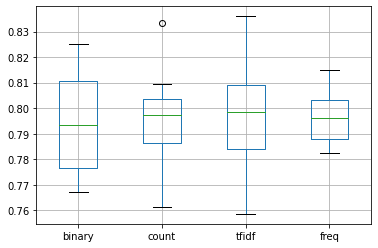

In [24]:
import seaborn as sns

results.boxplot()
plt.show()

## Summary

In [25]:
results

,binary,count,tfidf,freq
0,0.772487,0.809524,0.812169,0.806878
1,0.814815,0.804233,0.835979,0.814815
2,0.796296,0.796296,0.798942,0.796296
3,0.767196,0.801587,0.788360,0.788360
4,0.806878,0.833333,0.801587,0.801587
5,0.811671,0.790451,0.811671,0.787798
6,0.774536,0.771883,0.771883,0.782493
7,0.790451,0.761273,0.782493,0.787798
8,0.824934,0.785146,0.758621,0.803714
9,0.782493,0.798409,0.798409,0.795756


In [26]:
results.describe()

,binary,count,tfidf,freq
count,10.000000,10.000000,10.000000,10.000000
mean,0.794176,0.795214,0.796011,0.796550
std,0.019940,0.020032,0.022037,0.010195
min,0.767196,0.761273,0.758621,0.782493
25%,0.776525,0.786472,0.783960,0.787939
50%,0.793374,0.797352,0.798675,0.796026
75%,0.810473,0.803571,0.809150,0.803182
max,0.824934,0.833333,0.835979,0.814815


In [27]:
report = results
report = report.to_excel('BoW_MLP_CR_3.xlsx', sheet_name='model_3')

# Training and Testing the Model 2

## MLP Model 2

Now, we will build Multilayer Perceptron (MLP) models to classify encoded documents as either positive or negative.

As you might have expected, the models are simply feedforward network with fully connected layers called `Dense` in the `Keras` library.

Now, we will define our MLP neural network with very little trial and error so cannot be considered tuned for this problem. The configuration is as follows:
- First hidden layer with 100 neurons and Relu activation function
- Dropout layer with p = 0.5
- Output layer with Sigmoid activation function
- Optimizer: Adam (The best learning algorithm so far)
- Loss function: binary cross-entropy (suited for binary classification problem)

In [28]:
def train_mlp_2(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

## Train and Test the Model

In [29]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

def train_mlp_2(train_x, train_y, test_x, test_y, batch_size = 50, epochs = 20, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose, callbacks = [callbacks], validation_data=(test_x, test_y))
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

acc_list = []

# kfold.split() will return set indices for each split
for train, test in kfold.split(sentences):
    # Instantiate a vocab object
    vocab = Counter()
    
    train_x, test_x = [], []
    train_y, test_y = [], []
    
    for i in train:
        train_x.append(sentences[i])
        train_y.append(labels[i])
    
    for i in test:
        test_x.append(sentences[i])
        test_y.append(labels[i])
    
    # Turn the labels into a numpy array
    train_y = np.array(train_y)
    test_y = np.array(test_y)
    
    # Define a vocabulary for each fold
    vocab = add_doc_to_vocab(train_x, vocab)
    # print('The number of vocab: ', len(vocab))
    
    # Clean the sentences
    train_x = clean_docs(train_x, vocab)
    test_x = clean_docs(test_x, vocab)
    
    # Define the tokenizer
    tokenizer = create_tokenizer(train_x)
    
    # encode data using freq mode
    Xtrain = tokenizer.texts_to_matrix(train_x, mode='freq')
    Xtest = tokenizer.texts_to_matrix(test_x, mode='freq')
       
    # train the model
    model = train_mlp_2(Xtrain, train_y, Xtest, test_y)
    
    # evaluate the model
    loss, acc = model.evaluate(Xtest, test_y, verbose=0)
    print('Test Accuracy: {}'.format(acc*100))
    
    acc_list.append(acc)

acc_list = np.array(acc_list)
print()
print('The test ccuracy for each training:\n{}'.format(acc_list))
print('The mean of the test accuracy: ', acc_list.mean())

C:\Users\Diardano Raihan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass shuffle=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Epoch 1/20
68/68 - 3s - loss: 0.6617 - accuracy: 0.6353 - val_loss: 0.6567 - val_accuracy: 0.5979
Epoch 2/20
68/68 - 1s - loss: 0.6186 - accuracy: 0.6420 - val_loss: 0.6254 - val_accuracy: 0.5979
Epoch 3/20
68/68 - 1s - loss: 0.5682 - accuracy: 0.6685 - val_loss: 0.5757 - val_accuracy: 0.6772
Epoch 4/20
68/68 - 1s - loss: 0.5021 - accuracy: 0.7736 - val_loss: 0.5255 - val_accuracy: 0.7116
Epoch 5/20
68/68 - 1s - loss: 0.4406 - accuracy: 0.8360 - val_loss: 0.4976 - val_accuracy: 0.7116
Epoch 6/20
68/68 - 1s - loss: 0.3920 - accuracy: 0.8605 - val_loss: 0.4834 - val_accuracy: 0.7169
Epoch 7/20
68/68 - 1s - loss: 0.3551 - accuracy: 0.8714 - val_loss: 0.4701 - val_accuracy: 0.7619
Epoch 8/20
68/68 - 1s - loss: 0.3254 - accuracy: 0.8840 - val_loss: 0.4709 - val_accuracy: 0.7434
Epoch 9/20
68/68 - 1s - loss: 0.3011 - accuracy: 0.8940 - val_loss: 0.4748 - val_accuracy: 0.7381
Epoch 10/20
68/68 - 1s - loss: 0.2754 - accuracy: 0.9037 - val_loss: 0.4690 - val_accuracy: 0.7593
Epoch 11/20
68/68 -

Epoch 12/20
68/68 - 1s - loss: 0.2381 - accuracy: 0.9223 - val_loss: 0.4101 - val_accuracy: 0.7958
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Test Accuracy: 82.22811818122864
Epoch 1/20
68/68 - 2s - loss: 0.6617 - accuracy: 0.6371 - val_loss: 0.6418 - val_accuracy: 0.6260
Epoch 2/20
68/68 - 1s - loss: 0.6172 - accuracy: 0.6389 - val_loss: 0.6117 - val_accuracy: 0.6260
Epoch 3/20
68/68 - 1s - loss: 0.5661 - accuracy: 0.6672 - val_loss: 0.5656 - val_accuracy: 0.7029
Epoch 4/20
68/68 - 1s - loss: 0.5035 - accuracy: 0.7696 - val_loss: 0.5252 - val_accuracy: 0.7613
Epoch 5/20
68/68 - 1s - loss: 0.4419 - accuracy: 0.8323 - val_loss: 0.4985 - val_accuracy: 0.7613
Epoch 6/20
68/68 - 1s - loss: 0.3944 - accuracy: 0.8540 - val_loss: 0.4818 - val_accuracy: 0.7692
Epoch 7/20
68/68 - 1s - loss: 0.3571 - accuracy: 0.8661 - val_loss: 0.4733 - val_accuracy: 0.7692
Epoch 8/20
68/68 - 1s - loss: 0.3247 - accuracy: 0.8846 - val_loss: 0.4708 - val_accuracy: 0.7639


## Comparing the Word Scoring Methods

When we use `text_to_matrix()` function, we are given 4 different methods for scoring words:
- `binary`: words are marked as 1 (present) or 0 (absent)
- `count`: words are counted based on their occurrence (integer)
- `tfidf`: words are scored  based on their frequency of occurrence in their own document, but also are being penalized if they are common across  all documents
- `freq`: wrods are scored based on their frequency of occurrence in their own document

In [31]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

def train_mlp_2(train_x, train_y, test_x, test_y, batch_size = 50, epochs = 20, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose, callbacks = [callbacks], validation_data=(test_x, test_y))
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

# Run Experiment of 4 different modes
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()

for mode in modes:
    print('mode: ', mode)
    acc_list = []
    
    # kfold.split() will return set indices for each split
    for train, test in kfold.split(sentences):
        # Instantiate a vocab object
        vocab = Counter()

        train_x, test_x = [], []
        train_y, test_y = [], []

        for i in train:
            train_x.append(sentences[i])
            train_y.append(labels[i])

        for i in test:
            test_x.append(sentences[i])
            test_y.append(labels[i])

        # Turn the labels into a numpy array
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        # Define a vocabulary for each fold
        vocab = add_doc_to_vocab(train_x, vocab)
        # print('The number of vocab: ', len(vocab))

        # Clean the sentences
        train_x = clean_docs(train_x, vocab)
        test_x = clean_docs(test_x, vocab)

        # encode data using freq mode
        Xtrain, Xtest = prepare_data(train_x, test_x, mode)

        # train the model
        model = train_mlp_2(Xtrain, train_y, Xtest, test_y, verbose=0)

        # evaluate the model
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print('Test Accuracy: {}'.format(acc*100))

        acc_list.append(acc)
    
    results[mode] = acc_list
    acc_list = np.array(acc_list)
    print('The test ccuracy for each training:\n{}'.format(acc_list))
    print('The mean of the test accuracy: ', acc_list.mean())
    print()

print(results)

mode:  binary
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping
Test Accuracy: 79.62962985038757
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
Test Accuracy: 79.89417910575867
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping
Test Accuracy: 80.95238208770752
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Test Accuracy: 75.66137313842773
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping
Test Accuracy: 79.89417910575867
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Test Accuracy: 76.65782570838928
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Test Accuracy: 80.63660264015198
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Test Accuracy: 74.80106353759766
Restoring model weights from the end of the best e

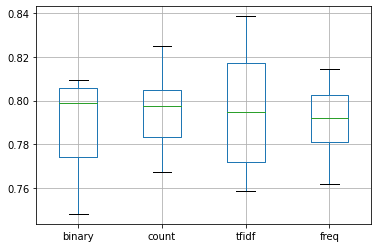

In [32]:
results.boxplot()
plt.show()

## Summary

In [33]:
results

,binary,count,tfidf,freq
0,0.796296,0.814815,0.767196,0.777778
1,0.798942,0.767196,0.806878,0.791005
2,0.809524,0.793651,0.817460,0.780423
3,0.756614,0.796296,0.838624,0.761905
4,0.798942,0.806878,0.820106,0.783069
5,0.766578,0.779841,0.816976,0.793103
6,0.806366,0.798409,0.779841,0.803714
7,0.748011,0.798409,0.758621,0.814324
8,0.803714,0.824934,0.769231,0.798409
9,0.809019,0.771883,0.782493,0.806366


In [34]:
results.describe()

,binary,count,tfidf,freq
count,10.000000,10.000000,10.000000,10.000000
mean,0.789400,0.795231,0.795743,0.791010
std,0.023145,0.018237,0.027494,0.015625
min,0.748011,0.767196,0.758621,0.761905
25%,0.774008,0.783293,0.771883,0.781085
50%,0.798942,0.797352,0.794686,0.792054
75%,0.805703,0.804761,0.817339,0.802387
max,0.809524,0.824934,0.838624,0.814324


In [35]:
report = results
report = report.to_excel('BoW_MLP_CR_2.xlsx', sheet_name='model_2')

# Training and Testing the Model 1

## MLP Model 1

Now, we will build Multilayer Perceptron (MLP) models to classify encoded documents as either positive or negative.

As you might have expected, the models are simply feedforward network with fully connected layers called `Dense` in the `Keras` library.

Now, we will define our MLP neural network with very little trial and error so cannot be considered tuned for this problem. The configuration is as follows:
- First hidden layer with 50 neurons and Relu activation function
- Dropout layer with p = 0.5
- Output layer with Sigmoid activation function
- Optimizer: Adam (The best learning algorithm so far)
- Loss function: binary cross-entropy (suited for binary classification problem)

In [36]:
def train_mlp_1(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=50, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

## Train and Test the Model

In [37]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

def train_mlp_1(train_x, train_y, test_x, test_y, batch_size = 50, epochs = 20, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=50, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose, callbacks = [callbacks], validation_data=(test_x, test_y))
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

acc_list = []

# kfold.split() will return set indices for each split
for train, test in kfold.split(sentences):
    # Instantiate a vocab object
    vocab = Counter()
    
    train_x, test_x = [], []
    train_y, test_y = [], []
    
    for i in train:
        train_x.append(sentences[i])
        train_y.append(labels[i])
    
    for i in test:
        test_x.append(sentences[i])
        test_y.append(labels[i])
    
    # Turn the labels into a numpy array
    train_y = np.array(train_y)
    test_y = np.array(test_y)
    
    # Define a vocabulary for each fold
    vocab = add_doc_to_vocab(train_x, vocab)
    # print('The number of vocab: ', len(vocab))
    
    # Clean the sentences
    train_x = clean_docs(train_x, vocab)
    test_x = clean_docs(test_x, vocab)
    
    # Define the tokenizer
    tokenizer = create_tokenizer(train_x)
    
    # encode data using freq mode
    Xtrain = tokenizer.texts_to_matrix(train_x, mode='freq')
    Xtest = tokenizer.texts_to_matrix(test_x, mode='freq')
       
    # train the model
    model = train_mlp_1(Xtrain, train_y, Xtest, test_y)
    
    # evaluate the model
    loss, acc = model.evaluate(Xtest, test_y, verbose=0)
    print('Test Accuracy: {}'.format(acc*100))
    
    acc_list.append(acc)

acc_list = np.array(acc_list)
print()
print('The test ccuracy for each training:\n{}'.format(acc_list))
print('The mean of the test accuracy: ', acc_list.mean())

C:\Users\Diardano Raihan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass shuffle=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Epoch 1/20
68/68 - 5s - loss: 0.6704 - accuracy: 0.6279 - val_loss: 0.6419 - val_accuracy: 0.6561
Epoch 2/20
68/68 - 1s - loss: 0.6340 - accuracy: 0.6356 - val_loss: 0.6178 - val_accuracy: 0.6561
Epoch 3/20
68/68 - 1s - loss: 0.6013 - accuracy: 0.6438 - val_loss: 0.5888 - val_accuracy: 0.6772
Epoch 4/20
68/68 - 1s - loss: 0.5503 - accuracy: 0.7077 - val_loss: 0.5595 - val_accuracy: 0.7407
Epoch 5/20
68/68 - 1s - loss: 0.5028 - accuracy: 0.7907 - val_loss: 0.5278 - val_accuracy: 0.7328
Epoch 6/20
68/68 - 1s - loss: 0.4547 - accuracy: 0.8207 - val_loss: 0.5082 - val_accuracy: 0.7725
Epoch 7/20
68/68 - 2s - loss: 0.4147 - accuracy: 0.8463 - val_loss: 0.4934 - val_accuracy: 0.7778
Epoch 8/20
68/68 - 1s - loss: 0.3888 - accuracy: 0.8631 - val_loss: 0.4849 - val_accuracy: 0.7725
Epoch 9/20
68/68 - 1s - loss: 0.3567 - accuracy: 0.8764 - val_loss: 0.4751 - val_accuracy: 0.7751
Epoch 10/20
68/68 - 1s - loss: 0.3374 - accuracy: 0.8861 - val_loss: 0.4714 - val_accuracy: 0.7751
Epoch 11/20
68/68 -

Epoch 13/20
68/68 - 1s - loss: 0.2896 - accuracy: 0.9011 - val_loss: 0.4380 - val_accuracy: 0.8037
Epoch 14/20
68/68 - 2s - loss: 0.2710 - accuracy: 0.9088 - val_loss: 0.4430 - val_accuracy: 0.8117
Epoch 15/20
68/68 - 1s - loss: 0.2562 - accuracy: 0.9164 - val_loss: 0.4419 - val_accuracy: 0.8196
Epoch 16/20
68/68 - 1s - loss: 0.2492 - accuracy: 0.9173 - val_loss: 0.4459 - val_accuracy: 0.8090
Epoch 17/20
68/68 - 1s - loss: 0.2364 - accuracy: 0.9200 - val_loss: 0.4523 - val_accuracy: 0.8011
Epoch 18/20
68/68 - 1s - loss: 0.2265 - accuracy: 0.9273 - val_loss: 0.4505 - val_accuracy: 0.8143
Epoch 19/20
68/68 - 1s - loss: 0.2159 - accuracy: 0.9297 - val_loss: 0.4610 - val_accuracy: 0.7984
Epoch 20/20
68/68 - 1s - loss: 0.2054 - accuracy: 0.9341 - val_loss: 0.4622 - val_accuracy: 0.8037
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
Test Accuracy: 81.9628655910492
Epoch 1/20
68/68 - 3s - loss: 0.6696 - accuracy: 0.6330 - val_loss: 0.6544 - val_accuracy: 0

## Comparing the Word Scoring Methods

When we use `text_to_matrix()` function, we are given 4 different methods for scoring words:
- `binary`: words are marked as 1 (present) or 0 (absent)
- `count`: words are counted based on their occurrence (integer)
- `tfidf`: words are scored  based on their frequency of occurrence in their own document, but also are being penalized if they are common across  all documents
- `freq`: wrods are scored based on their frequency of occurrence in their own document

In [38]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

def train_mlp_1(train_x, train_y, test_x, test_y, batch_size = 50, epochs = 20, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=50, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose, callbacks = [callbacks], validation_data=(test_x, test_y))
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

# Run Experiment of 4 different modes
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()

for mode in modes:
    print('mode: ', mode)
    acc_list = []
    
    # kfold.split() will return set indices for each split
    for train, test in kfold.split(sentences):
        # Instantiate a vocab object
        vocab = Counter()

        train_x, test_x = [], []
        train_y, test_y = [], []

        for i in train:
            train_x.append(sentences[i])
            train_y.append(labels[i])

        for i in test:
            test_x.append(sentences[i])
            test_y.append(labels[i])

        # Turn the labels into a numpy array
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        # Define a vocabulary for each fold
        vocab = add_doc_to_vocab(train_x, vocab)
        # print('The number of vocab: ', len(vocab))

        # Clean the sentences
        train_x = clean_docs(train_x, vocab)
        test_x = clean_docs(test_x, vocab)

        # encode data using freq mode
        Xtrain, Xtest = prepare_data(train_x, test_x, mode)

        # train the model
        model = train_mlp_1(Xtrain, train_y, Xtest, test_y, verbose=0)

        # evaluate the model
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print('Test Accuracy: {}'.format(acc*100))

        acc_list.append(acc)
    
    results[mode] = acc_list
    acc_list = np.array(acc_list)
    print('The test ccuracy for each training:\n{}'.format(acc_list))
    print('The mean of the test accuracy: ', acc_list.mean())
    print()

print(results)

mode:  binary
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Test Accuracy: 78.83597612380981
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping
Test Accuracy: 80.95238208770752
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Test Accuracy: 78.57142686843872
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Test Accuracy: 79.36508059501648
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Test Accuracy: 77.51322984695435
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
Test Accuracy: 79.57559823989868
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Test Accuracy: 79.0450930595398
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
Test Accuracy: 80.10610342025757
Restoring model weights from the end of the best ep

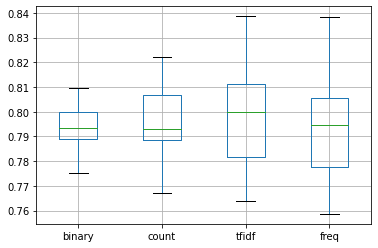

In [39]:
results.boxplot()
plt.show()

## Summary

In [40]:
results

,binary,count,tfidf,freq
0,0.788360,0.788360,0.780423,0.775132
1,0.809524,0.777778,0.796296,0.814815
2,0.785714,0.767196,0.838624,0.788360
3,0.793651,0.806878,0.769841,0.806878
4,0.775132,0.788360,0.809524,0.801587
5,0.795756,0.811671,0.803714,0.785146
6,0.790451,0.790451,0.811671,0.758621
7,0.801061,0.806366,0.785146,0.838196
8,0.793103,0.795756,0.811671,0.801061
9,0.809019,0.822281,0.763926,0.766578


In [41]:
results.describe()

,binary,count,tfidf,freq
count,10.000000,10.000000,10.000000,10.000000
mean,0.794177,0.795510,0.797084,0.793637
std,0.010484,0.016563,0.022638,0.023871
min,0.775132,0.767196,0.763926,0.758621
25%,0.788883,0.788360,0.781604,0.777636
50%,0.793377,0.793103,0.800005,0.794710
75%,0.799735,0.806750,0.811134,0.805556
max,0.809524,0.822281,0.838624,0.838196


In [42]:
report = results
report = report.to_excel('BoW_MLP_CR_1.xlsx', sheet_name='model_1')